In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v5 import Autoencoder
from tools.GRU_AR_v5 import AR_RNN_GRU as RNN_GRU

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpoin?tAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2022-11-20 12:51:18.302453: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 12:51:18.302708: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 12:51:18.335767: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 12:51:18.336028: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 12:51:18.336331: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [10]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [11]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_014'

    # making AR-RNN save directory
    dir_name_ARrnn = os.getcwd() + dir_sep + 'saved_AR_rnn'
    if not os.path.isdir(dir_name_ARrnn):
        os.makedirs(dir_name_ARrnn)

    counter = 0
    while True:
        dir_check = 'AR_rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ARrnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ARrnn = dir_name_ARrnn + dir_sep + dir_check
    os.makedirs(dir_name_ARrnn)
    os.makedirs(dir_name_ARrnn+dir_sep+'plots')
    
    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
    try:
        use_ae_data = params_rnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in RNN_specific_data, set to True.")
        use_ae_data = True
        
    
    # training params
    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0

    loss_weights = 0.98
else:
    # AR-RNN directory
    dir_name_ARrnn = os.getcwd()+'/saved_AR_rnn/AR_rnn_000'

    # reading AR-RNN parameters
    with open(dir_name_ARrnn + '/AR_rnn_specific_data.txt') as f:
        lines = f.readlines()
    
    params_AR_rnn_dict = eval(''.join(lines))

    dir_name_rnn = params_AR_rnn_dict['dir_name_rnn']
    rnn_idx = dir_name_rnn[-3:]
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_'+rnn_idx

    dt_rnn = params_AR_rnn_dict['dt_rnn']
    T_sample_input = params_AR_rnn_dict['T_sample_input']
    T_sample_output = params_AR_rnn_dict['T_sample_output']
    T_offset = params_AR_rnn_dict['T_offset']
    return_params_arr = params_AR_rnn_dict['return_params_arr']
    params = params_AR_rnn_dict['params']
    try:
        normalize_dataset = params_AR_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in AR_rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_AR_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_AR_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        use_ae_data = params_AR_rnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in RNN_specific_data, set to True.")
        use_ae_data = True

    # training params
    with open(dir_name_ARrnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0
    try:
        loss_weights = tparams_dict['loss_weights']
    except:
        loss_weights = None


# reading stddev
with open(dir_name_rnn + '/final_net/final_net_class_dict.txt') as f:
    lines = f.readlines()
finalnet_dict = eval(''.join(lines))
stddev = finalnet_dict['stddev']
stddev = 0.0

# reading RNN normalization constants
normalization_arr_rnn = None
if normalize_dataset == True:
    with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
        lines = f.readlines()
    normarr_rnn_dict = eval(''.join(lines))
    normalization_arr_rnn = normarr_rnn_dict['normalization_arr']

if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
    fl = np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True)
    normalization_arr = fl['normalization_arr'][0]

# reading AE directory
with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
    lines = f.readlines()

params_dict = eval(''.join(lines))

dir_name_ae = params_dict['dir_name_ae']
ae_idx = dir_name_ae[-3:]
dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in RNN_specific_data, set to True.")
    ae_data_with_params = True

print('dir_name_ARrnn:', dir_name_ARrnn)
print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state_mat = params_dict['init_state_mat']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

fl = np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True)
all_data = fl['all_data']
boundary_idx_arr = fl['boundary_idx_arr']
normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
initial_t0 = fl['initial_t0']
init_state_mat = fl['init_state_mat']
lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']


test_split = 1 - train_split - val_split

# setting seed for PRNGs
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

'use_ae_data' not present in RNN_specific_data, set to True.
dir_name_ARrnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006
dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_014
dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_046
data_dir_idx: 005
normalize_flag_ogdata: False


In [12]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [13]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

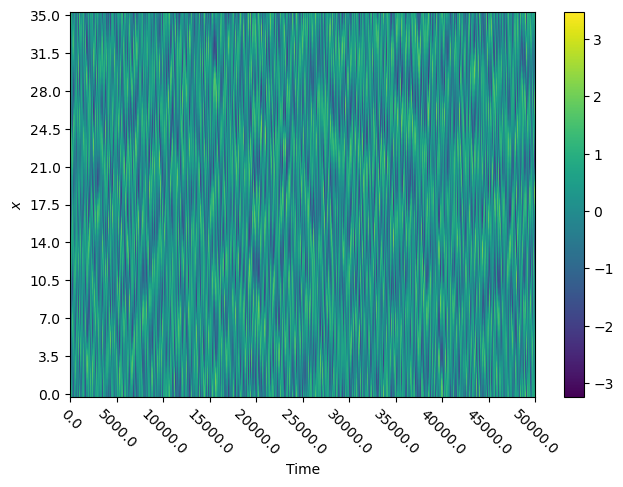

In [14]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

In [15]:
# delaing with normalizing the data before feeding into autoencoder
if normalizeforae_flag == True:
    for i in range(numpoints_xgrid):
        all_data[:, i] -= normalization_constant_arr_aedata[0, i]
        all_data[:, i] /= normalization_constant_arr_aedata[1, i]
if ae_data_with_params == False:
    all_data = all_data[:, 0:numpoints_xgrid]

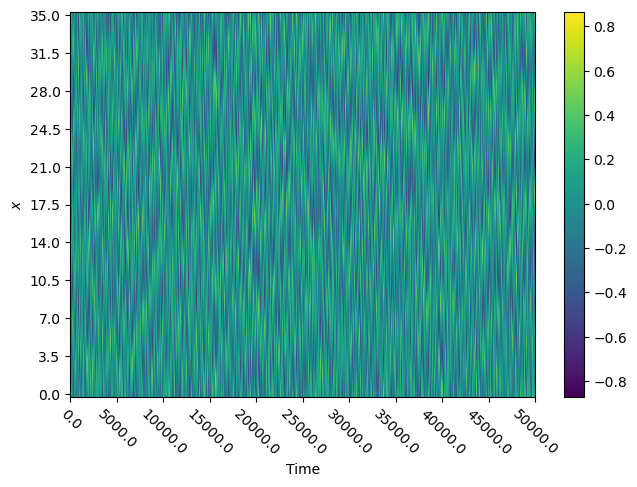

In [16]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

# Autoencoder

In [17]:
# load_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_class_dict.txt'
# wt_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_ae_weights.h5'

# if colab_flag == False:
#     dir_name_ae_og = dir_name_ae
#     dir_name_ae_temp = '/home/rkaushik/Documents/Thesis/MLROM/CDV/saved_ae/ae_'+ae_idx
#     dir_name_ae = dir_name_ae_temp

load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

# if colab_flag == False:
#     dir_name_ae = dir_name_ae_og

In [18]:
ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
ae_net.load_weights_from_file(wt_file)

In [19]:
# create data
if use_ae_data == True:
    latent_states_all = ae_net.encoder_net.predict(all_data)
    del(all_data)
else:
    latent_states_all = all_data[:, 0:xgrid.shape[0]]
num_latent_states = latent_states_all.shape[1]

time_stddev = np.std(latent_states_all, axis=0)

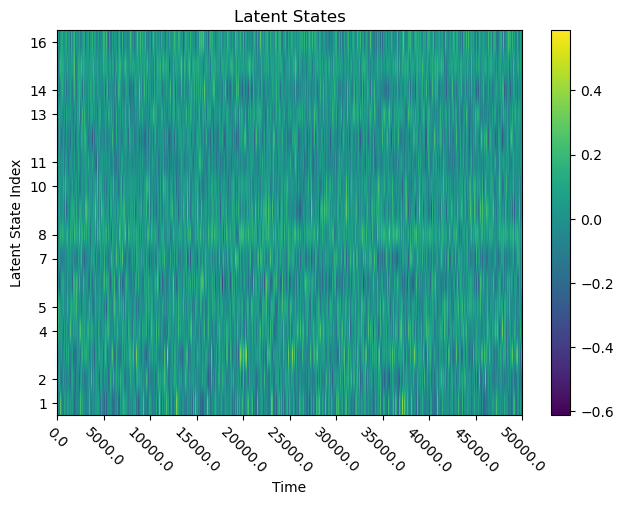

In [20]:
plot_latent_states_KS(
    boundary_idx_arr,
    latent_states_all,
    delta_t,
    dir_name_ae,
    xticks_snapto=int(40*np.round((T//10)/40)),
    num_yticks=11,
    save_figs=False)

In [21]:
# for i in range(ae_net.layers):
#     tf.keras.utils.plot_model(
#         ae_net.layers[i],
#         to_file=dir_name_ae+'/plots/netlayer_{}.png'.format(i),
#         show_shapes=True,
#         dpi=300
# )

# GRU

In [22]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = 10*dt_rnn/np.mean(lyapunov_time_arr)
    num_timesteps_warmup = 1*np.mean(lyapunov_time_arr)/dt_rnn
    T_sample_input = num_timesteps_warmup*dt_rnn
    T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = T_sample_input
    skip_intermediate = 1/2
    if return_params_arr != False:
        params = params_arr
    else:
        params = None

    # saving AR RNN specific data
    AR_RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'num_timesteps_warmup':num_timesteps_warmup,
        'dir_name_rnn':dir_name_rnn,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':RNN_GRU.__module__,
        'normalization_type':normalization_type,
        'use_ae_data':use_ae_data,
    }

    with open(dir_name_ARrnn+dir_sep+'AR_RNN_specific_data.txt', 'w') as f:
        f.write(str(AR_RNN_specific_data))

In [23]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    normalization_arr_external=normalization_arr_rnn,
    return_OrgDataIdxArr=False,
    skip_intermediate=skip_intermediate,
)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [24]:
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)

In [25]:
print(' data_rnn_input.shape :', data_rnn_input.shape)
print('data_rnn_output.shape :', data_rnn_output.shape)

 data_rnn_input.shape : (5746, 77, 16)
data_rnn_output.shape : (5746, 10, 16)


In [26]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [2e-6, 1e-6]
    epochs = 200
    patience = 25 # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1e-4  # weight for regularizer

    if loss_weights is None:
        loss_weights = [1.0]*data_rnn_output.shape[1]
    elif isinstance(loss_weights, list) == False:
        loss_weights = list(loss_weights**np.arange(data_rnn_output.shape[1]))
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'loss_weights':loss_weights,
    }

    with open(dir_name_ARrnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_ARrnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr],
    )

In [27]:
# idx = np.arange(data_rnn_input.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round(train_split*data_rnn_input.shape[0]))

# training_data_rnn_input = data_rnn_input[idx[0:boundary]]
# training_data_rnn_output = data_rnn_output[idx[0:boundary]]

# testing_data_rnn_input = data_rnn_input[idx[boundary:]]
# testing_data_rnn_output = data_rnn_output[idx[boundary:]]

In [28]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train = 0
num_val = 0
begin_idx = 0
for i in range(len(boundary_idx_arr)):
    num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
    num_train += int(train_split*num_samples)
    num_val += int(val_split*num_samples)
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [num_train]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [num_train]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [num_val]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [num_train]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [cum_samples-num_train-num_val]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [cum_samples-num_train-num_val]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape)
training_data_rnn_output = np.empty(shape=training_output_shape)

val_data_rnn_input = np.empty(shape=val_input_shape)
val_data_rnn_output = np.empty(shape=val_output_shape)

testing_data_rnn_input = np.empty(shape=testing_input_shape)
testing_data_rnn_output = np.empty(shape=testing_output_shape)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    num_samples = idx.shape[0]
    num_train = int(train_split*num_samples)
    num_val = int(val_split*num_samples)

    training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    num_test = num_samples-num_train-num_val+1
    testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_input[idx[num_train+num_val:]]
    testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_output[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# cleaning up
del(data_rnn_input)
del(data_rnn_output)
    
# further shuffling
idx = np.arange(0, training_data_rnn_input.shape[0])
np.random.shuffle(idx)
training_data_rnn_input = training_data_rnn_input[idx]
training_data_rnn_output = training_data_rnn_output[idx]

idx = np.arange(0, val_data_rnn_input.shape[0])
np.random.shuffle(idx)
val_data_rnn_input = val_data_rnn_input[idx]
val_data_rnn_output = val_data_rnn_output[idx]

idx = np.arange(0, testing_data_rnn_input.shape[0])
np.random.shuffle(idx)
testing_data_rnn_input = testing_data_rnn_input[idx]
testing_data_rnn_output = testing_data_rnn_output[idx]

del(idx)

In [29]:
print(' training_data_rnn_input.shape : ', training_data_rnn_input.shape)
print('training_data_rnn_output.shape : ', training_data_rnn_output.shape)
print('\n  testing_data_rnn_input.shape : ', testing_data_rnn_input.shape)
print(' testing_data_rnn_output.shape : ', testing_data_rnn_output.shape)
print('\n      val_data_rnn_input.shape : ', val_data_rnn_input.shape)
print('     val_data_rnn_output.shape : ', val_data_rnn_output.shape)

 training_data_rnn_input.shape :  (4596, 77, 16)
training_data_rnn_output.shape :  (4596, 10, 16)

  testing_data_rnn_input.shape :  (576, 77, 16)
 testing_data_rnn_output.shape :  (576, 10, 16)

      val_data_rnn_input.shape :  (574, 77, 16)
     val_data_rnn_output.shape :  (574, 10, 16)


In [30]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    load_file = dir_name_rnn + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'

    if strategy is not None:
        with strategy.scope():
            rnn_net = RNN_GRU(
                load_file=load_file,
                T_input=T_sample_input,
                T_output=T_sample_output,
                stddev=stddev,
            )
    else:
        rnn_net = RNN_GRU(
            load_file=load_file,
            T_input=T_sample_input,
            T_output=T_sample_output,
            stddev=stddev,
        )
    save_path = dir_name_ARrnn+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    rnn_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
    wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'final_net_gru_weights.h5'
else:
    load_file = dir_name_ARrnn + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    if strategy is not None:
        with strategy.scope():
            rnn_net = RNN_GRU(
                load_file=load_file,
                stddev=stddev
            )
    else:
        rnn_net = RNN_GRU(
            load_file=load_file,
            stddev=stddev
        )
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_ARrnn+dir_sep+'checkpoints')
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_ARrnn+dir_sep+'final_net'+dir_sep+'final_net_gru_weights.h5'
        # wt_file = dir_name_ARrnn+dir_sep+'final_net'+dir_sep+'f2'#+dir_sep+'saved_model.pb'
rnn_net.load_weights_from_file(wt_file)

In [31]:
# comment this out if not residual RNN
# rnn_net.rnn_cells_list[0].trainable = False

In [32]:
# compiling the network
rnn_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
    loss=losses.MeanSquaredError(),
    run_eagerly=False,
    loss_weights=loss_weights,
    metrics='mse'
)

if behaviour == 'loadCheckpointAndContinueTraining':
    # this loads the weights/attributes of the optimizer as well
    if strategy is not None:
        with strategy.scope():
            rnn_net.load_weights(wt_file)
    else:
        rnn_net.load_weights(wt_file)

In [33]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
    earlystopping_wait = 0
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt, earlystopping_wait = readAndReturnLossHistories(
        dir_name_ae=dir_name_ARrnn,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=learning_rate_list,
        return_earlystopping_wait=True)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_ARrnn+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [34]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    # implementing early stopping
    baseline = None
    if behaviour == 'loadCheckpointAndContinueTraining':
        baseline = np.min(val_loss_hist)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta,
        baseline=baseline
    )
    #** the two lines below are useless because wait is set to 0 in on_train_begin
    # early_stopping_cb.wait = earlystopping_wait
    # print('early_stopping_cb.wait : {}\n'.format(early_stopping_cb.wait))

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_ARrnn+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        initial_value_threshold=baseline,
        period=1  # saves every `period` epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=1)

    for i in range(starting_lr_idx, len(learning_rate_list)):
        learning_rate = learning_rate_list[i]
        K.set_value(rnn_net.optimizer.lr, learning_rate)

        savelosses_cb.update_lr_idx(i)

        if i == starting_lr_idx:
            EPOCHS = num_epochs_left
            savelosses_cb.update_offset(epochs-num_epochs_left)
        else:
            EPOCHS = epochs
            savelosses_cb.update_offset(0)

        total_s_len = 80
        sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
        sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
        sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
        print('\n\n' + '-'*len(sep_lr_s))
        print('\n' + sep_lr_s+'\n')
        print('-'*len(sep_lr_s) + '\n\n')
        
        history = rnn_net.fit(training_data_rnn_input, training_data_rnn_output,
            epochs=EPOCHS,
            batch_size=batch_size,
#             validation_split=val_split/train_split,
            validation_data=(val_data_rnn_input, val_data_rnn_output),
            callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb],
            verbose=1
        )

        val_loss_hist.extend(history.history['val_loss'])
        train_loss_hist.extend(history.history['loss'])
        
        if i == starting_lr_idx:
            lr_change[i+1] += len(history.history['val_loss'])
        else:
            lr_change.append(lr_change[i]+len(history.history['val_loss']))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 2e-06 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
72/72 [==============================] - ETA: 0s - loss: 3.6041e-04 - mse: 2.9410e-04 - tot_time: 0h 0m 33.9s

Epoch 1: val_loss improved from inf to 0.00037, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/LossHistoriesCheckpoint
72/72 [==============================] - 34s 145ms/step - loss: 3.6041e-04 - mse: 2.9410e-04 - val_loss: 3.6752e-04 - val_mse: 3.0121e-04
Epoch 2/200
72/72 [==============================] - ETA: 0s - loss: 3.5870e-04 - mse: 2.9239e-04 - tot_time: 0h 0m 42.1s

Epoch 2: val_loss improved from 0.00037 to 0.00037, saving model to /home/rkaushik/Doc

Epoch 17/200
72/72 [==============================] - ETA: 0s - loss: 3.5016e-04 - mse: 2.8391e-04 - tot_time: 0h 2m 44.0s

Epoch 17: val_loss did not improve from 0.00036
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/LossHistoriesCheckpoint
72/72 [==============================] - 8s 111ms/step - loss: 3.5016e-04 - mse: 2.8391e-04 - val_loss: 3.6416e-04 - val_mse: 2.9791e-04
Epoch 18/200
72/72 [==============================] - ETA: 0s - loss: 3.5043e-04 - mse: 2.8419e-04 - tot_time: 0h 2m 52.0s

Epoch 18: val_loss did not improve from 0.00036
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/LossHistoriesCheckpoint
72/72 [==============================] - 8s 112ms/step - loss: 3.5043e-04 - mse: 2.8419e-04 - val_loss: 3.6413e-04 - val_mse: 2.9788e-04
Epoch 19/200
72/72 [==============================] - ETA: 0s - loss: 3.4951e-04 - mse: 2.8327e-04 - tot_time: 0h 3m 0.1s

E

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/LossHistoriesCheckpoint
72/72 [==============================] - 8s 115ms/step - loss: 3.4514e-04 - mse: 2.7896e-04 - val_loss: 3.6100e-04 - val_mse: 2.9483e-04
Epoch 35/200
72/72 [==============================] - ETA: 0s - loss: 3.4482e-04 - mse: 2.7864e-04 - tot_time: 0h 5m 10.3s

Epoch 35: val_loss did not improve from 0.00036
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/LossHistoriesCheckpoint
72/72 [==============================] - 8s 111ms/step - loss: 3.4482e-04 - mse: 2.7864e-04 - val_loss: 3.6112e-04 - val_mse: 2.9495e-04
Epoch 36/200
72/72 [==============================] - ETA: 0s - loss: 3.4458e-04 - mse: 2.7841e-04 - tot_time: 0h 5m 18.1s

Epoch 36: val_loss did not improve from 0.00036
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/LossHistoriesCheckp

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/LossHistoriesCheckpoint
72/72 [==============================] - 8s 111ms/step - loss: 3.4094e-04 - mse: 2.7484e-04 - val_loss: 3.5930e-04 - val_mse: 2.9320e-04
Epoch 53/200
72/72 [==============================] - ETA: 0s - loss: 3.4091e-04 - mse: 2.7482e-04 - tot_time: 0h 7m 35.3s

Epoch 53: val_loss improved from 0.00036 to 0.00036, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/LossHistoriesCheckpoint
72/72 [==============================] - 8s 112ms/step - loss: 3.4091e-04 - mse: 2.7482e-04 - val_loss: 3.5742e-04 - val_mse: 2.9132e-04
Epoch 54/200
72/72 [==============================] - ETA: 0s - loss: 3.4014e-04 - mse: 2.7405e-04 - tot_time: 0h 7m 43.5s

Epoch 54: val_loss did not improve from 0.00036
 - saving loss 

72/72 [==============================] - ETA: 0s - loss: 3.3781e-04 - mse: 2.7178e-04 - tot_time: 0h 9m 52.7s

Epoch 70: val_loss did not improve from 0.00036
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/LossHistoriesCheckpoint
72/72 [==============================] - 8s 112ms/step - loss: 3.3781e-04 - mse: 2.7178e-04 - val_loss: 3.5624e-04 - val_mse: 2.9022e-04
Epoch 71/200
72/72 [==============================] - ETA: 0s - loss: 3.3693e-04 - mse: 2.7090e-04 - tot_time: 0h 10m 0.8s

Epoch 71: val_loss did not improve from 0.00036
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/LossHistoriesCheckpoint
72/72 [==============================] - 8s 112ms/step - loss: 3.3693e-04 - mse: 2.7090e-04 - val_loss: 3.5650e-04 - val_mse: 2.9048e-04
Epoch 72/200
72/72 [==============================] - ETA: 0s - loss: 3.3668e-04 - mse: 2.7066e-04 - tot_time: 0h 10m 8.8s

Epoch 72: val

Epoch 88/200
72/72 [==============================] - ETA: 0s - loss: 3.3376e-04 - mse: 2.6780e-04 - tot_time: 0h 12m 17.7s

Epoch 88: val_loss did not improve from 0.00035
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/LossHistoriesCheckpoint
72/72 [==============================] - 8s 113ms/step - loss: 3.3376e-04 - mse: 2.6780e-04 - val_loss: 3.5529e-04 - val_mse: 2.8933e-04
Epoch 89/200
72/72 [==============================] - ETA: 0s - loss: 3.3299e-04 - mse: 2.6703e-04 - tot_time: 0h 12m 25.6s

Epoch 89: val_loss improved from 0.00035 to 0.00035, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/LossHistoriesCheckpoint
72/72 [==============================] - 8s 110ms/step - loss: 3.3299e-04 - mse: 2.6703e-04 - val_loss: 3.5313e-04 - val_mse: 2.8717e-04
Epoch 90/200


Epoch 106/200
72/72 [==============================] - ETA: 0s - loss: 3.3040e-04 - mse: 2.6449e-04 - tot_time: 0h 14m 43.5s

Epoch 106: val_loss did not improve from 0.00035
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/LossHistoriesCheckpoint
72/72 [==============================] - 8s 113ms/step - loss: 3.3040e-04 - mse: 2.6449e-04 - val_loss: 3.5165e-04 - val_mse: 2.8575e-04
Epoch 107/200
72/72 [==============================] - ETA: 0s - loss: 3.3017e-04 - mse: 2.6427e-04 - tot_time: 0h 14m 51.6s

Epoch 107: val_loss improved from 0.00035 to 0.00035, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/LossHistoriesCheckpoint
72/72 [==============================] - 8s 114ms/step - loss: 3.3017e-04 - mse: 2.6427e-04 - val_loss: 3.5036e-04 - val_mse: 2.8446e-04
Epoch 108

Epoch 124/200
72/72 [==============================] - ETA: 0s - loss: 3.2765e-04 - mse: 2.6180e-04 - tot_time: 0h 17m 8.9s

Epoch 124: val_loss did not improve from 0.00035
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/LossHistoriesCheckpoint
72/72 [==============================] - 8s 110ms/step - loss: 3.2765e-04 - mse: 2.6180e-04 - val_loss: 3.4892e-04 - val_mse: 2.8307e-04
Epoch 125/200
72/72 [==============================] - ETA: 0s - loss: 3.2728e-04 - mse: 2.6142e-04 - tot_time: 0h 17m 16.8s

Epoch 125: val_loss did not improve from 0.00035
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/LossHistoriesCheckpoint
72/72 [==============================] - 8s 108ms/step - loss: 3.2728e-04 - mse: 2.6142e-04 - val_loss: 3.4934e-04 - val_mse: 2.8349e-04
Epoch 126/200
72/72 [==============================] - ETA: 0s - loss: 3.2697e-04 - mse: 2.6113e-04 - tot_time: 0h 17m 

Epoch 142/200
72/72 [==============================] - ETA: 0s - loss: 3.2436e-04 - mse: 2.5856e-04 - tot_time: 0h 19m 34.3s

Epoch 142: val_loss improved from 0.00035 to 0.00034, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/LossHistoriesCheckpoint
72/72 [==============================] - 8s 113ms/step - loss: 3.2436e-04 - mse: 2.5856e-04 - val_loss: 3.4476e-04 - val_mse: 2.7895e-04
Epoch 143/200
72/72 [==============================] - ETA: 0s - loss: 3.2513e-04 - mse: 2.5932e-04 - tot_time: 0h 19m 42.3s

Epoch 143: val_loss did not improve from 0.00034
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/LossHistoriesCheckpoint
72/72 [==============================] - 8s 111ms/step - loss: 3.2513e-04 - mse: 2.5932e-04 - val_loss: 3.4518e-04 - val_mse: 2.7937e-04
Epoch 144

Epoch 160/200
72/72 [==============================] - ETA: 0s - loss: 3.2218e-04 - mse: 2.5642e-04 - tot_time: 0h 21m 59.8s

Epoch 160: val_loss did not improve from 0.00034
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/LossHistoriesCheckpoint
72/72 [==============================] - 8s 111ms/step - loss: 3.2218e-04 - mse: 2.5642e-04 - val_loss: 3.4448e-04 - val_mse: 2.7872e-04
Epoch 161/200
72/72 [==============================] - ETA: 0s - loss: 3.2183e-04 - mse: 2.5606e-04 - tot_time: 0h 22m 7.7s

Epoch 161: val_loss did not improve from 0.00034
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/LossHistoriesCheckpoint
72/72 [==============================] - 8s 111ms/step - loss: 3.2183e-04 - mse: 2.5606e-04 - val_loss: 3.4418e-04 - val_mse: 2.7842e-04
Epoch 162/200
72/72 [==============================] - ETA: 0s - loss: 3.2160e-04 - mse: 2.5584e-04 - tot_time: 0h 22m 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/LossHistoriesCheckpoint
72/72 [==============================] - 8s 114ms/step - loss: 3.1947e-04 - mse: 2.5374e-04 - val_loss: 3.4068e-04 - val_mse: 2.7495e-04
Epoch 178/200
72/72 [==============================] - ETA: 0s - loss: 3.1981e-04 - mse: 2.5408e-04 - tot_time: 0h 24m 25.3s

Epoch 178: val_loss did not improve from 0.00034
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/LossHistoriesCheckpoint
72/72 [==============================] - 8s 113ms/step - loss: 3.1981e-04 - mse: 2.5408e-04 - val_loss: 3.4146e-04 - val_mse: 2.7573e-04
Epoch 179/200
72/72 [==============================] - ETA: 0s - loss: 3.1858e-04 - mse: 2.5285e-04 - tot_time: 0h 24m 33.2s

Epoch 179: val_loss improved from 0.00034 to 0.00034, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/checkpoint
 - saving

Epoch 195/200
72/72 [==============================] - ETA: 0s - loss: 3.1666e-04 - mse: 2.5097e-04 - tot_time: 0h 26m 42.2s

Epoch 195: val_loss improved from 0.00034 to 0.00034, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/LossHistoriesCheckpoint
72/72 [==============================] - 8s 113ms/step - loss: 3.1666e-04 - mse: 2.5097e-04 - val_loss: 3.3805e-04 - val_mse: 2.7235e-04
Epoch 196/200
72/72 [==============================] - ETA: 0s - loss: 3.1685e-04 - mse: 2.5116e-04 - tot_time: 0h 26m 50.4s

Epoch 196: val_loss did not improve from 0.00034
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/LossHistoriesCheckpoint
72/72 [==============================] - 8s 112ms/step - loss: 3.1685e-04 - mse: 2.5116e-04 - val_loss: 3.3811e-04 - val_mse: 2.7241e-04
Epoch 197

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/LossHistoriesCheckpoint
72/72 [==============================] - 8s 115ms/step - loss: 3.1308e-04 - mse: 2.4740e-04 - val_loss: 3.3582e-04 - val_mse: 2.7014e-04
Epoch 12/200
72/72 [==============================] - ETA: 0s - loss: 3.1262e-04 - mse: 2.4694e-04 - tot_time: 0h 29m 0.2s

Epoch 12: val_loss did not improve from 0.00034
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/LossHistoriesCheckpoint
72/72 [==============================] - 8s 113ms/step - loss: 3.1262e-04 - mse: 2.4694e-04 - val_loss: 3.3639e-04 - val_mse: 2.7072e-04
Epoch 13/200
72/72 [==============================] - ETA: 0s - loss: 3.1272e-04 - mse: 2.4705e-04 - tot_time: 0h 29m 8.2s

Epoch 13: val_loss did not improve from 0.00034
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/LossHistoriesCheckp

72/72 [==============================] - ETA: 0s - loss: 3.1134e-04 - mse: 2.4568e-04 - tot_time: 0h 31m 18.6s

Epoch 29: val_loss did not improve from 0.00033
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/LossHistoriesCheckpoint
72/72 [==============================] - 8s 113ms/step - loss: 3.1134e-04 - mse: 2.4568e-04 - val_loss: 3.3543e-04 - val_mse: 2.6976e-04
Epoch 30/200
72/72 [==============================] - ETA: 0s - loss: 3.1149e-04 - mse: 2.4582e-04 - tot_time: 0h 31m 26.8s

Epoch 30: val_loss did not improve from 0.00033
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/LossHistoriesCheckpoint
72/72 [==============================] - 8s 114ms/step - loss: 3.1149e-04 - mse: 2.4582e-04 - val_loss: 3.3519e-04 - val_mse: 2.6953e-04
Epoch 31/200
72/72 [==============================] - ETA: 0s - loss: 3.1163e-04 - mse: 2.4597e-04 - tot_time: 0h 31m 35.0s

Epoch 31: 

Epoch 47/200
72/72 [==============================] - ETA: 0s - loss: 3.1051e-04 - mse: 2.4486e-04 - tot_time: 0h 33m 45.6s

Epoch 47: val_loss did not improve from 0.00033
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/LossHistoriesCheckpoint
72/72 [==============================] - 8s 113ms/step - loss: 3.1051e-04 - mse: 2.4486e-04 - val_loss: 3.3353e-04 - val_mse: 2.6788e-04
Epoch 48/200
72/72 [==============================] - ETA: 0s - loss: 3.1015e-04 - mse: 2.4450e-04 - tot_time: 0h 33m 53.6s

Epoch 48: val_loss did not improve from 0.00033
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/LossHistoriesCheckpoint
72/72 [==============================] - 8s 111ms/step - loss: 3.1015e-04 - mse: 2.4450e-04 - val_loss: 3.3530e-04 - val_mse: 2.6965e-04
Epoch 49/200
72/72 [==============================] - ETA: 0s - loss: 3.1024e-04 - mse: 2.4458e-04 - tot_time: 0h 34m 1.8s

Epoch 65/200
72/72 [==============================] - ETA: 0s - loss: 3.0886e-04 - mse: 2.4321e-04 - tot_time: 0h 36m 11.3s

Epoch 65: val_loss did not improve from 0.00033
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/LossHistoriesCheckpoint
72/72 [==============================] - 8s 113ms/step - loss: 3.0886e-04 - mse: 2.4321e-04 - val_loss: 3.3290e-04 - val_mse: 2.6726e-04
Epoch 66/200
72/72 [==============================] - ETA: 0s - loss: 3.0900e-04 - mse: 2.4336e-04 - tot_time: 0h 36m 19.4s

Epoch 66: val_loss improved from 0.00033 to 0.00033, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/LossHistoriesCheckpoint
72/72 [==============================] - 8s 114ms/step - loss: 3.0900e-04 - mse: 2.4336e-04 - val_loss: 3.3209e-04 - val_mse: 2.6645e-04
Epoch 67/200


Epoch 83/200
72/72 [==============================] - ETA: 0s - loss: 3.0768e-04 - mse: 2.4205e-04 - tot_time: 0h 38m 36.9s

Epoch 83: val_loss did not improve from 0.00033
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/LossHistoriesCheckpoint
72/72 [==============================] - 8s 115ms/step - loss: 3.0768e-04 - mse: 2.4205e-04 - val_loss: 3.3186e-04 - val_mse: 2.6623e-04
Epoch 84/200
72/72 [==============================] - ETA: 0s - loss: 3.0778e-04 - mse: 2.4215e-04 - tot_time: 0h 38m 44.9s

Epoch 84: val_loss improved from 0.00033 to 0.00033, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/LossHistoriesCheckpoint
72/72 [==============================] - 8s 112ms/step - loss: 3.0778e-04 - mse: 2.4215e-04 - val_loss: 3.3139e-04 - val_mse: 2.6576e-04
Epoch 85/200


Epoch 101/200
72/72 [==============================] - ETA: 0s - loss: 3.0671e-04 - mse: 2.4109e-04 - tot_time: 0h 41m 2.9s

Epoch 101: val_loss did not improve from 0.00033
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/LossHistoriesCheckpoint
72/72 [==============================] - 8s 112ms/step - loss: 3.0671e-04 - mse: 2.4109e-04 - val_loss: 3.3090e-04 - val_mse: 2.6528e-04
Epoch 102/200
72/72 [==============================] - ETA: 0s - loss: 3.0642e-04 - mse: 2.4080e-04 - tot_time: 0h 41m 10.9s

Epoch 102: val_loss improved from 0.00033 to 0.00033, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/LossHistoriesCheckpoint
72/72 [==============================] - 8s 113ms/step - loss: 3.0642e-04 - mse: 2.4080e-04 - val_loss: 3.2986e-04 - val_mse: 2.6424e-04
Epoch 103/

Epoch 119/200
72/72 [==============================] - ETA: 0s - loss: 3.0547e-04 - mse: 2.3986e-04 - tot_time: 0h 43m 29.4s

Epoch 119: val_loss improved from 0.00033 to 0.00033, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/LossHistoriesCheckpoint
72/72 [==============================] - 8s 114ms/step - loss: 3.0547e-04 - mse: 2.3986e-04 - val_loss: 3.2851e-04 - val_mse: 2.6290e-04
Epoch 120/200
72/72 [==============================] - ETA: 0s - loss: 3.0532e-04 - mse: 2.3971e-04 - tot_time: 0h 43m 37.6s

Epoch 120: val_loss did not improve from 0.00033
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/LossHistoriesCheckpoint
72/72 [==============================] - 8s 113ms/step - loss: 3.0532e-04 - mse: 2.3971e-04 - val_loss: 3.3054e-04 - val_mse: 2.6492e-04
Epoch 121

Epoch 137/200
72/72 [==============================] - ETA: 0s - loss: 3.0402e-04 - mse: 2.3842e-04 - tot_time: 0h 45m 55.1s

Epoch 137: val_loss did not improve from 0.00033
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/LossHistoriesCheckpoint
72/72 [==============================] - 8s 114ms/step - loss: 3.0402e-04 - mse: 2.3842e-04 - val_loss: 3.2890e-04 - val_mse: 2.6330e-04
Epoch 138/200
72/72 [==============================] - ETA: 0s - loss: 3.0408e-04 - mse: 2.3848e-04 - tot_time: 0h 46m 3.2s

Epoch 138: val_loss improved from 0.00033 to 0.00033, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/LossHistoriesCheckpoint
72/72 [==============================] - 8s 114ms/step - loss: 3.0408e-04 - mse: 2.3848e-04 - val_loss: 3.2816e-04 - val_mse: 2.6255e-04
Epoch 139/

72/72 [==============================] - ETA: 0s - loss: 3.0300e-04 - mse: 2.3741e-04 - tot_time: 0h 48m 21.4s

Epoch 155: val_loss did not improve from 0.00033
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/LossHistoriesCheckpoint
72/72 [==============================] - 8s 110ms/step - loss: 3.0300e-04 - mse: 2.3741e-04 - val_loss: 3.2737e-04 - val_mse: 2.6178e-04
Epoch 156/200
72/72 [==============================] - ETA: 0s - loss: 3.0299e-04 - mse: 2.3740e-04 - tot_time: 0h 48m 29.6s

Epoch 156: val_loss did not improve from 0.00033
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_rnn/AR_rnn_006/checkpoints/LossHistoriesCheckpoint
72/72 [==============================] - 8s 114ms/step - loss: 3.0299e-04 - mse: 2.3740e-04 - val_loss: 3.2737e-04 - val_mse: 2.6178e-04
Epoch 157/200
72/72 [==============================] - ETA: 0s - loss: 3.0283e-04 - mse: 2.3724e-04 - tot_time: 0h 48m 37.7s

Epoch 

In [35]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    test_loss = rnn_net.evaluate(
        testing_data_rnn_input, testing_data_rnn_output,
    )

    save_path = dir_name_ARrnn+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
            'lr_change':lr_change,
            'test_loss':test_loss
        }))
        
    if normalize_dataset == True:
        with open(save_path+dir_sep+'rnn_normalization.txt', 'w') as f:
            f.write(str({
                'normalization_arr':normalization_arr
            }))

    rnn_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

18/18 [==============================] - 2s 31ms/step - loss: 3.3030e-04 - mse: 2.6470e-04


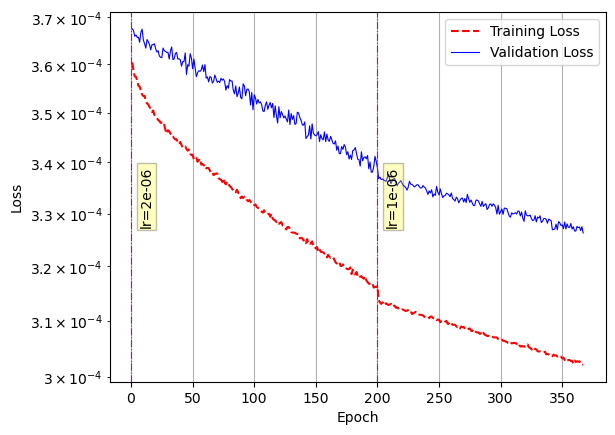

In [36]:
# plotting losses
dir_name_plot = dir_name_ARrnn+dir_sep+'plots'
if not os.path.isdir(dir_name_plot):
    os.makedirs(dir_name_plot)

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list
)

plt.savefig(dir_name_plot+'{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


data_idx : 544


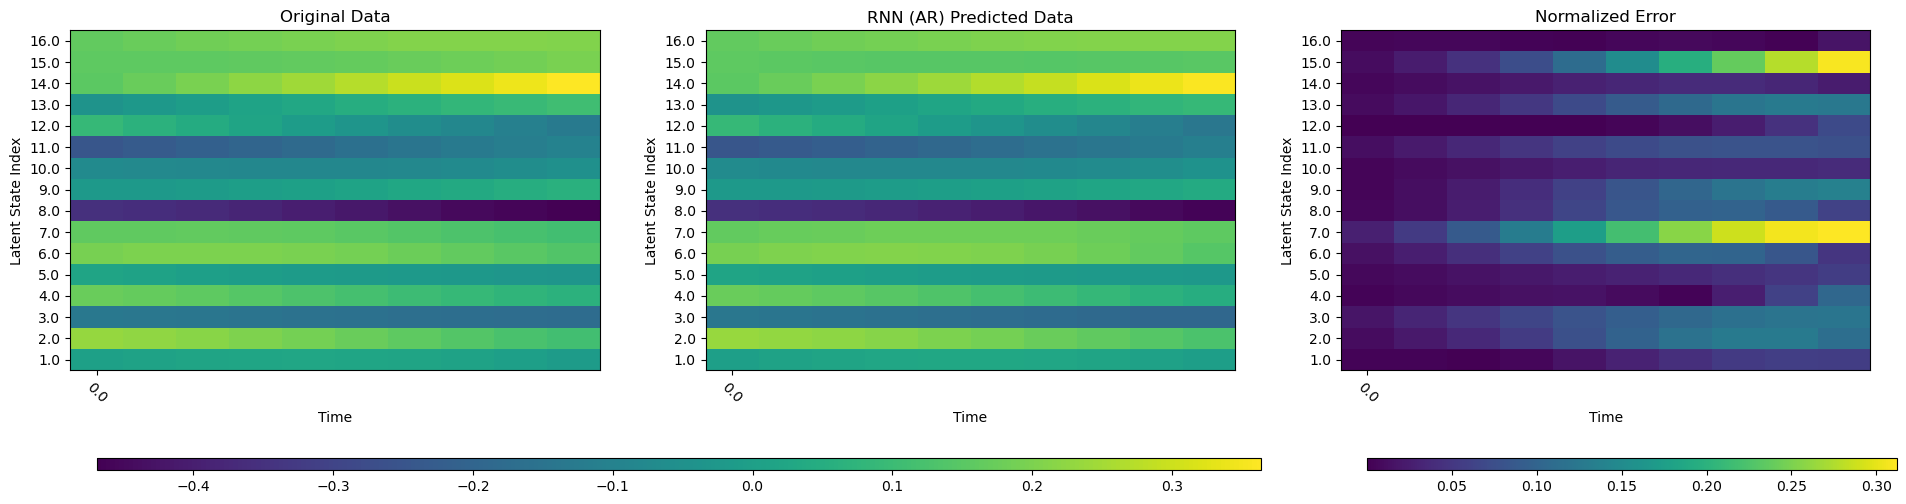

In [37]:
# data_type = 'training'
data_type = 'testing'

data_in = eval(data_type+'_data_rnn_input')
data_out = eval(data_type+'_data_rnn_output')

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 3788
print('data_idx : {}'.format(data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]

prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])

plot_reconstructed_data_KS(
    [data_out.shape[0]],
    dir_name_ARrnn,
    data_out,
    prediction[0], dt_rnn, 1+np.arange(0, data_out.shape[1]),
    save_figs=False,
    normalization_constant_arr=normalization_arr,
    xticks_snapto=2,
    num_yticks=data_out.shape[1],
    ylabel=r'Latent State Index',
    ax1_title=r'Original Data',
    ax2_title=r'RNN (AR) Predicted Data')

In [38]:
prediction.shape, data_out.shape

((1, 10, 16), (10, 16))

In [39]:
def rescale_data(data, normalization_arr):
    '''
    data - [num_batches x num_timesteps x num_states]
    normalization_arr = [2 x num_states]
    '''
    new_data = data.copy()
    shape = new_data.shape
    for i in range(data.shape[-1]):
        new_data[:, i] -= normalization_arr[0, i]
        new_data[:, i] /= normalization_arr[1, i]

    return new_data

def norm_sq_time_average(data):
    data_norm_sq = np.zeros(shape=data.shape[0])
    for i in range(data.shape[1]):
        data_norm_sq[:] += data[:, i]**2
    # integrating using the trapezoidal rule
    norm_sq_time_avg = np.sum(data_norm_sq) - 0.5*(data_norm_sq[0]+data_norm_sq[-1])
    norm_sq_time_avg /= data_norm_sq.shape[0]
    return norm_sq_time_avg

def invert_normalization(data, normalization_arr):
    new_data = data.copy()
    shape = new_data.shape
    for i in range(shape[-1]):
        if len(shape) == 2:
            new_data[:, i] *= normalization_arr[1, i]
            new_data[:, i] += normalization_arr[0, i]
        elif len(shape) == 3:
            new_data[:, :, i] *= normalization_arr[1, i]
            new_data[:, :, i] += normalization_arr[0, i]
    return new_data

case 1, data_idx : 3


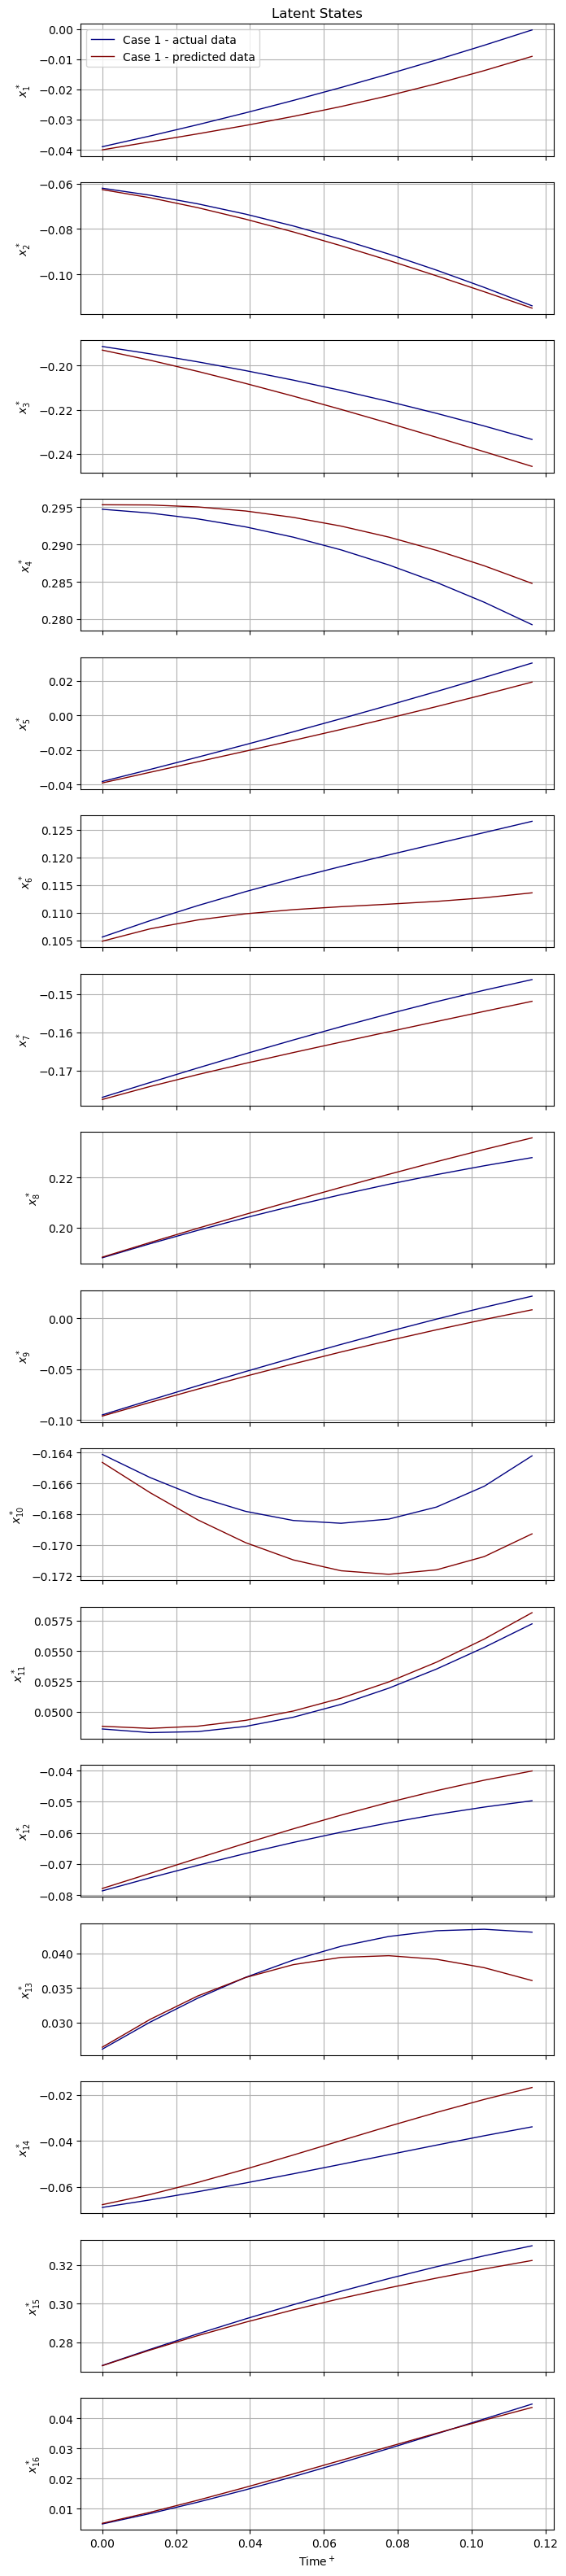

IndexError: index 0 is out of bounds for axis 0 with size 0

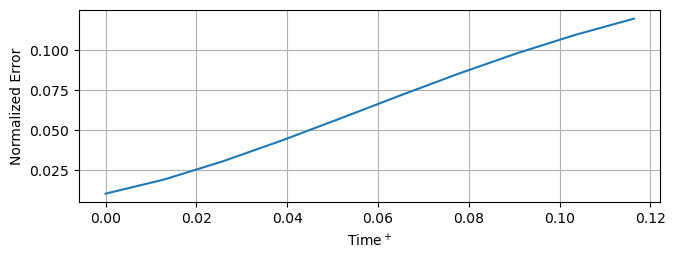

In [40]:
# data_type = 'training'
data_type = 'testing'

data_in = eval(data_type+'_data_rnn_input')
data_out = eval(data_type+'_data_rnn_output')

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    if data_idx < rnn_data_boundary_idx_arr[i]:
        case_idx = i
        break
lyap_time = lyapunov_time_arr[case_idx]

print('case {}, data_idx : {}'.format(case_idx+1, data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]
# data_out = rescale_data(data_out, normalization_arr)
data_out = invert_normalization(data_out, normalization_arr)

prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])
# prediction = rnn_net(data_in[data_idx:data_idx+1, :, :], training=False)
# prediction = rnn_net.call(data_in[data_idx:data_idx+1, :, :], training=False)
prediction = invert_normalization(prediction, normalization_arr)

n = 1
num_latent_states = data_out.shape[-1]
N = data_out.shape[0]

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = ['$x^*_{' +str(i)+'}$' for i in range(1, num_latent_states+1)]

fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]
input_time = np.arange(0, N)*dt_rnn/lyap_time

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

mpl_ax_artist_list = []
for j in range(num_latent_states):
    for i in range(n):
        obj_in = ax[j].plot(input_time, data_out[:, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        obj_out = ax[j].plot(input_time, prediction[0, :, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
        mpl_ax_artist_list.append(obj_in[0])
        mpl_ax_artist_list.append(obj_out[0])
    ax[j].set_ylabel(ax_ylabels[j])
    # if xlim is not None:
    #     ax[j].set_xlim(xlim)
    # if ylim is not None:
    #     ax[j].set_ylim(ylim)
    ax[j].grid(True)
    ax[j].set_axisbelow(True)


ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
ax[0].legend(
    loc='best',
    ncol=ncols,
)
ax[0].set_title(r'Latent States', size=12)
plt.show()
# plt.savefig('AR-GRU.png', dpi=300, bbox_inches='tight')
print('')

### Error and prediction horizon
# error = np.linalg.norm(data_out[:, :] - prediction[0, :, :], axis=1)
error = (data_out[:, :] - prediction[0, :, :])**2
# error /= norm_sq_time_average(data_out)**0.5
error = np.linalg.norm(np.divide(error, time_stddev**2), axis=1)**0.5

# print(norm_sq_time_average(data_out)**0.5)

fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
ax2.plot(input_time, error)
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_xlabel('Time$^+$')
ax2.set_ylabel('Normalized Error')

error_threshold = 0.5

predhor_idx = np.where(error >= error_threshold)[0][0]
ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')

prediction_horizon = predhor_idx*dt_rnn/lyap_time
print(prediction_horizon)



plt.show()